In [1]:
import os
import sys
import glob
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

In [3]:
samples = []
for file in glob.glob('*.fastq'):
    descriptors = file.split('_')
    treatment = descriptors[0]
    read = descriptors[-2]
    samples += [pd.DataFrame({'treatment':[treatment], 'read_pair':[read], 
                                  'file_name':[file]})]
samples = pd.concat(samples)
samples = samples.sort_values(by=['treatment']).reset_index().drop(columns=['index'])
samples

,treatment,read_pair,file_name
0,NT-1,R2,NT-1_R2_001.fastq
1,NT-2,R2,NT-2_R2_001.fastq
2,NTC-1,R2,NTC-1_R2_001.fastq
3,NTC-2,R2,NTC-2_R2_001.fastq
4,siRNA1-1,R2,siRNA1-1_R2_001.fastq
5,siRNA1-2,R2,siRNA1-2_R2_001.fastq
6,siRNA2-1,R2,siRNA2-1_R2_001.fastq
7,siRNA2-2,R2,siRNA2-2_R2_001.fastq


In [4]:
#From each sample, search all reads for the template switch oligo (TSO) sequence.
#For reads containing a perfect match to the TSO, store everything after the TSO as the "fluseq".
#Fluseq is 5' end of flu mRNA, including the sequence snatched from the host.
fluseqs_all = {}
for file in glob.glob('*.fastq'):
    sample = file.split('_')[0]
    with open(file) as infile:
        fluseqs_df = []
        linenum = 1
        for line in infile:
            if linenum%4 == 2:
                read = line
                TSO = re.search('AAGCAGTGGTATCAACGCAGAGTACAT.GG', read)
                if TSO is not None:
                    fluseq = read[TSO.end():]
                    fluseqs_df += [pd.DataFrame({'fluseq':[fluseq]})]
            linenum += 1
        fluseqs_df = pd.concat(fluseqs_df)
        fluseqs_all[sample] = fluseqs_df

for sample in fluseqs_all:
    df = fluseqs_all[sample]
    df.to_csv(f'fluseqs_{sample}.tsv', sep='\t')

{'siRNA1-2':                                                fluseq
 0   GCAGAGACCAAGGCAAAAGCAGGGTAGATAATCACTCACAGAGTGA...
 0   AATCATGGCGACCAAAGGCACCAAACGATCTTACGAACAGATGGAG...
 0   ATTCAGGGCTTGCAAAAGCAGGGTAGATAATCACTCACAGAGTGAC...
 0   GATTTCCTGCATGGCGAAAGCAGGCAAACCATTTGAATGGATGTCA...
 0   AATCATGGCGACCAAAGGCACCAAACGATCTTACGAACAGATGGAG...
 ..                                                ...
 0   GGCCCTGTGTTCATCTGCAAAAGCAGGGTAGATAATCACTCACAGA...
 0   AGAAAGTCCAAATGCGAAAGCAGGTCAATTATATTCAATATGGAAA...
 0   GCCTGAGTGGAAGCGAAAGCAGGTACTGATTCAAAATGGAAGATTT...
 0   ATGGCCCCGGGCAGCAAAAGCAAAAGCAGGGTAGATAATCACTCAC...
 0   ATCGCTTCTCGCGAAAGCAGGCAAACCATTTGAATGGATGTCAATC...
 
 [1661680 rows x 1 columns],
 'NTC-1':                                                fluseq
 0   GAGAGACGGTACCCGGAGCAAAAGCAGGTAGATATTGAAAGATGAG...
 0   GACATTTGAGGAGCAAAAGCAGGTAGATATTGAAAGATGAGTCTTC...
 0   ACACAGTGGGCAGCAAAAGCAGGGGAAAATAAAAACAACCAAAATG...
 0   ATACTTACCTGGCAAAAGCAGGGGAAAATAAAAACAACCAAAATGA...
 0   GATCGCTT

In [3]:
#Create a dictionary with the first 20 nucleotides of the mRNA from each flu segment

segments = {}

segments['polymeraseB2'] = 'GCGAAAGCAGGTCAATTATA'
segments['polymeraseB1'] = 'GCGAAAGCAGGCAAACCATT'
segments['polymeraseA'] = 'GCGAAAGCAGGTACTGATTC'
segments['hemaglutinin'] = 'GCAAAAGCAGGGGAAAATAA'
segments['nucleoprotein'] = 'GCAAAAGCAGGGTAGATAAT'
segments['neuraminidase'] = 'GCGAAAGCAGGAGTTTAAAT'
segments['matrix'] = 'GCAAAAGCAGGTAGATATTG'
segments['nonstructural'] = 'GCAAAAGCAGGGTGACAAAA' #PR8

In [8]:
#Search each "fluseq" for the start of the flu mRNA sequence.
#A match to the flu mRNA must have at least 15 nucleotide identity within the first 20 nt of the flu mRNA.
#The sequence between the TSO and the flu mRNA is considered the cap sequence.
#Store the cap sequences along with their length in the capseqs_all dictionary.

capseqs_all = {}
for sample in fluseqs_all:
    print(sample)
    fluseqs = fluseqs_all[sample]
    capseqs = []
    for ind in fluseqs.index:
        seq = fluseqs.fluseq[ind]
        max_match = 14
        max_seg = 'None'
        max_pos = -1
        for pos in range(len(seq)-20):
            check = seq[pos:pos+20]
            for seg in segments:
                matches = sum(a==b for a,b in zip(check, segments[seg]))
                if matches < 10:
                    break
                if matches > max_match:
                    max_match = matches
                    max_seg = seg
                    max_pos = pos
                if matches == 20:
                    break
            if matches == 20:
                break
        if max_match > 14:
            capseq = seq[:max_pos]
            capseqs += [pd.DataFrame({'fluseq':[seq],'segment':[max_seg],'capseq':[capseq],'caplength':[len(capseq)]})]
    capseqs = pd.concat(capseqs)
    capseqs_all[sample] = capseqs
    capseqs.to_csv(f'capseqs_{sample}.tsv', sep='\t')
capseqs_all

NT-1
NT-2
NTC-1
siRNA1-2
siRNA2-1
siRNA2-2


{'NT-1':                                                fluseq        segment  \
 0   ATACTTACCTGGCAAAAGCAGGGTGACAAAGACATAATGGATCCAA...  nonstructural   
 0   GACGTGGGGAAGCAGCAAAAGCAGGGTGACAAAGACATAATGGATC...  nonstructural   
 0   ACTCGCCCCCTAGCAAAAGCAGGGTGACAAAGACATAATGGATCCA...  nonstructural   
 0   GATACTTACCTGGCAAAAGCAGGTAGATATTGAAAGATGAGTCTTC...         matrix   
 0   GAATTGTGCAGCAAAAGCAGGGTAGATAATCACTCACAGAGTGACA...  nucleoprotein   
 ..                                                ...            ...   
 0   AACCCACTGCTTAGCAAAAGCAGGGTGACAAAGACATAATGGATCC...  nonstructural   
 0   ATCGCTTCTCGCGCGAAAGCAGGCAAACCATTTGAATGGATGTCAA...   polymeraseB1   
 0   ACTCTCATCAGCAAAAGCAGGGTGACAAAGACATAATGGATCCAAA...  nonstructural   
 0   GACCTGCGGCATGCAAAAGCAGGTAGATATTGAAAGATGAGTCTTC...         matrix   
 0   AGGACGTGAGCGAAAGCAGGCAAACCATTTGAATGGATGTCAATCC...   polymeraseB1   
 
             capseq  caplength  
 0      ATACTTACCTG         11  
 0   GACGTGGGGAAGCA         14  
 0     ACTCGCCC

In [9]:
for sample in capseqs_all:
    med = capseqs_all[sample].caplength.median()
    mean = capseqs_all[sample].caplength.mean()
    minval = capseqs_all[sample].caplength.min()
    maxval = capseqs_all[sample].caplength.max()
    print(f'{sample} median: ' + str(med))
    print(f'{sample} mean: ' + str(mean))
    print(f'{sample} min: ' + str(minval))
    print(f'{sample} max: ' + str(maxval))

NT-1 median: 12.0
NT-1 mean: 11.946308116738058
NT-1 min: 0
NT-1 max: 51
NT-2 median: 12.0
NT-2 mean: 11.836836499911765
NT-2 min: 0
NT-2 max: 69
NTC-1 median: 12.0
NTC-1 mean: 11.940274795952568
NTC-1 min: 0
NTC-1 max: 91
NTC-2 median: 12.0
NTC-2 mean: 11.985433042575561
NTC-2 min: 0
NTC-2 max: 91
siRNA1-1 median: 12.0
siRNA1-1 mean: 11.972149483965234
siRNA1-1 min: 1
siRNA1-1 max: 73
siRNA1-2 median: 12.0
siRNA1-2 mean: 12.358563671431115
siRNA1-2 min: 0
siRNA1-2 max: 71
siRNA2-1 median: 12.0
siRNA2-1 mean: 12.28418162845615
siRNA2-1 min: 1
siRNA2-1 max: 53
siRNA2-2 median: 12.0
siRNA2-2 mean: 11.926320636929491
siRNA2-2 min: 1
siRNA2-2 max: 63


In [6]:
#Since there are many exact duplicate cap sequences, it looks like there was bottlenecking in the sample prep.
#Make a new dictionary with only unique cap sequences.

capseqs_unique = {}
for sample in samples.treatment:
    capseqs_unique[sample] = capseqs_all[sample].drop_duplicates(subset = 'fluseq', keep = 'first').reset_index()
    capseqs_unique[sample].to_csv(f'capseqs_unique_{sample}.tsv', sep='\t')

In [8]:
for sample in capseqs_unique:
    med = capseqs_unique[sample].caplength.median()
    mean = capseqs_unique[sample].caplength.mean()
    minval = capseqs_unique[sample].caplength.min()
    maxval = capseqs_unique[sample].caplength.max()
    print(f'{sample} median: ' + str(med))
    print(f'{sample} mean: ' + str(mean))
    print(f'{sample} min: ' + str(minval))
    print(f'{sample} max: ' + str(maxval))

NT-1 median: 12.0
NT-1 mean: 12.055460750853243
NT-1 min: 0
NT-1 max: 51
NT-2 median: 12.0
NT-2 mean: 11.926575656225193
NT-2 min: 0
NT-2 max: 69
NTC-1 median: 12.0
NTC-1 mean: 12.161108472176165
NTC-1 min: 0
NTC-1 max: 91
NTC-2 median: 12.0
NTC-2 mean: 12.127547552248767
NTC-2 min: 0
NTC-2 max: 91
siRNA1-1 median: 12.0
siRNA1-1 mean: 12.039373048318726
siRNA1-1 min: 1
siRNA1-1 max: 73
siRNA1-2 median: 12.0
siRNA1-2 mean: 12.542939690668144
siRNA1-2 min: 0
siRNA1-2 max: 71
siRNA2-1 median: 12.0
siRNA2-1 mean: 12.268426185784518
siRNA2-1 min: 1
siRNA2-1 max: 53
siRNA2-2 median: 12.0
siRNA2-2 mean: 11.943940346779264
siRNA2-2 min: 1
siRNA2-2 max: 63


In [ ]:
for sample in capseqs_all:
    df = capseqs_all[sample]
    df['treatment'] = sample.split('-')[0]
    df['replicate'] = sample.split('-')[1]

In [ ]:
capseqs_only = {}
for sample in capseqs_unique:
    df = capseqs_unique[sample]
    df = df[df.caplength <= df.caplength.quantile(0.98)] #omit top 2% of lengths for easier visualization
    lengths = df.caplength.tolist()
    capseqs_only[sample] = lengths

capseqs_unique_lengths = pd.DataFrame()
for sample in capseqs_only:
    lengths = capseqs_only[sample]
    df = pd.DataFrame({'lengths' : lengths})
    df['sample'] = sample
    capseqs_unique_lengths = pd.concat([capseqs_unique_lengths, df])

/tmp/ipykernel_1908201/2535041882.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.violinplot(data=capseqs_unique_lengths, x='sample', y='lengths', palette = sns.color_palette("colorblind"), bw_adjust=3, inner="box", cut=0)
/tmp/ipykernel_1908201/2535041882.py:1: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  ax=sns.violinplot(data=capseqs_unique_lengths, x='sample', y='lengths', palette = sns.color_palette("colorblind"), bw_adjust=3, inner="box", cut=0)


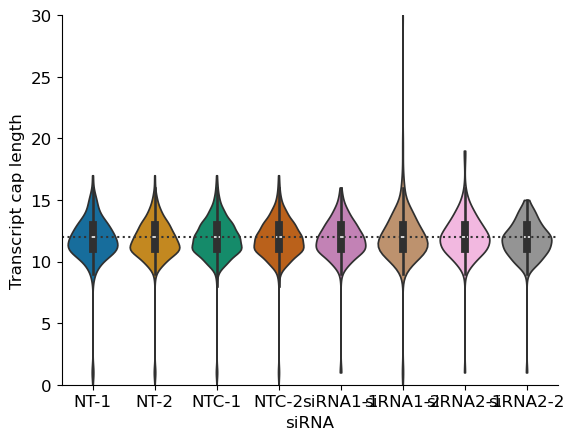

In [12]:
ax=sns.violinplot(data=capseqs_unique_lengths, x='sample', y='lengths', palette = sns.color_palette("colorblind"), bw_adjust=3, inner="box", cut=0)

sns.despine()
plt.ylabel('Transcript cap length')
plt.xlabel('siRNA')

med = capseqs_unique['NT-1'].caplength.median()
ax.axhline(med, linestyle=':', color='0.2')

plt.ylim(0,30)

plt.savefig('Figures/capseqs_unique_violin.pdf', format='pdf', bbox_inches = "tight")